In [1]:
from sympy import *
from sympy.solvers.solveset import linear_coeffs
import sympy.physics.mechanics as me
import numpy as np

init_printing()

def symb(x, y, z = ''):
    return symbols('{0}_{1}{2}'.format(x, y, z), type = float)

def apply2Eq(fun, eq):
    return Eq(fun(eq.lhs), fun(eq.rhs))


First, define variables:

In [2]:
X       = IndexedBase('X') # [-], non-dimensional displacement
B       = IndexedBase('B') # [-], non-dimensional face width
tau     = IndexedBase('tau') # [-], non-dimensional time
zeta    = IndexedBase('zeta') # [-], damping ratio
Sigma   = IndexedBase('Sigma') # [-], non-dimensional stress
F       = IndexedBase('F') # [-], non-dimensional force
mu      = IndexedBase('mu') # [-], non-dimensional force from stress
omega   = IndexedBase('omega') # [-], non-dimensional rotation speed
P       = IndexedBase('P') # [kW], power
Omega   = IndexedBase('Omega') # [RPM], rotation speed
sigma   = IndexedBase('sigma') # [Pa], stress
f       = IndexedBase('f') # [N], force
x       = IndexedBase('x') # [mm], displacement
m_n     = IndexedBase('m_n') # [mm], normal module
b       = IndexedBase('b') # [mm], dimensional face width
t       = IndexedBase('t') # [s], time
omega_0 = IndexedBase('omega_0') # [rad/s], normalizing frequency
c       = IndexedBase('c') # [N/m/s], damping
k       = IndexedBase('k') # [N/m], stiffness
m       = IndexedBase('m') # [kg], mass
rho     = IndexedBase('rho') # [kg/m**3], density
V       = IndexedBase('V') # [m**3], volume

par_nd = [X, B, tau, zeta, Sigma, F, mu, omega] # non-dimensional
par_dd = [Omega, sigma, f, x, m_n, b, t, c, k, m, rho, omega_0, P] # dimensional
par    = [*par_nd, *par_dd]

Given the following equations:
$$
    m \ddot{x} + c \dot{x} + k x = f(t) \\
    \sigma_F = C_F \frac{P}{\Omega b d_1 m_n}
$$
The nondimensional groups are given by:

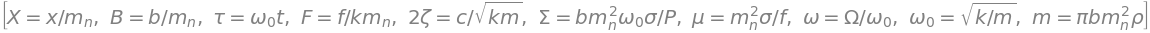

In [3]:
m_rel = Eq(m, rho*pi*b*m_n**2)

om_rel = Eq(omega_0, sqrt(k/m))
# om_rel = om_rel.subs(m, rho*V)
# om_rel = om_rel.subs(V, pi*b*m_n**2)

pi1 = Eq(X, x/m_n)

pi2 = Eq(B, b/m_n)

pi3 = Eq(tau, omega_0*t)
# pi3 = pi3.subs(om_rel.lhs, om_rel.rhs)

pi4 = Eq(F, f/(k*m_n))

pi5 = Eq(2*zeta, c/sqrt(m*k))
# pi5 = pi5.subs(m_rel.lhs, m_rel.rhs)

pi6 = Eq(Sigma, (sigma*omega_0*b*m_n**2)/P)
# pi6 = pi6.subs(om_rel.lhs, om_rel.rhs)
# pi6 = simplify(pi6)

pi7 = Eq(mu, (sigma*m_n**2)/f)

pi8 = Eq(omega, Omega/omega_0)
# pi8 = pi8.subs(om_rel.lhs, om_rel.rhs)

PI = [pi1, pi2, pi3, pi4, pi5, pi6, pi7, pi8]
PI_rel = [*PI, om_rel, m_rel]

display(PI_rel)

## Scaling factors:

In [4]:
log_simp = lambda x: expand_log(log(x), force = True)

PI_log = list(map(lambda x: apply2Eq(log_simp,x), PI_rel))

for q in PI_log:
    display(q)


In [5]:
def coeff_matrix(equations, *symbols):
    # adapted from the source code of sympy.linear_eq_to_matrix(equations, *symbols)
    A , b = [], []
    for i, f in enumerate(equations):
        coeff_list = linear_coeffs(f, *symbols)
        b.append(-coeff_list.pop())
        A.append(coeff_list)

    A, b = map(Matrix, (A, b))

    return A, b

In [6]:
def get_scaling_factors(PI_eq, pars):
    GM = IndexedBase('Gamma')

    for pp in pars:
        for i, e in enumerate(PI_eq):
            PI_eq[i] = PI_eq[i].subs(log(pp), GM[e])

    # one-sided version:
    PI_os  = list(map(lambda x: x.lhs - x.rhs, PI_eq))
    GM_par = list(map(lambda x: GM[x], pars))

    A, b = coeff_matrix(PI_os, *GM_par[:-1])
    x = A.pinv() @ b

#    res = A @ x - b
#    res = list(map(abs, res))
#    if sum(res) != 0:
#        print('ERROR!')
    
    x = x.subs(GM[P], log(P))

    display(A, b)
    for i, y in enumerate(x):
        display(Eq(GM[pars[i]], GM[P]**(y/log(P))))

    return x, A, b

### Complete similitude

In [17]:
PI_all = list(map(lambda x: x.subs([
                                    (sigma  , 1),   # keep structural safety
                                    (rho    , 1),   # same material
                                   # (t      , 1),   # same time scale
                                   # (tau    , 1),   # same time scale
                                    (log(pi), 0),   # get rid of this
                                    (log(2) , 0)]), # get rid of this
                                                    PI_log))
# same time scale:
# (tau    , 1), 

for q in PI_all:
    display(q)


In [18]:
# xx,aa,bb = get_scaling_factors(PI_all, par_dd)

Gamma = IndexedBase('Gamma')
gamma = IndexedBase('gamma')

PI_gm = PI_all

for elem in par:
    for i, p in enumerate(PI_gm):
        PI_gm[i] = PI_gm[i].subs(log(elem), Gamma[elem])

PI_gm  = list(map(lambda x: x.lhs - x.rhs, PI_gm))
gm_par = list(map(lambda x: Gamma[x], par_dd))

for q in PI_gm:
    display(Eq(q, 0))

mat_A, vec_b = coeff_matrix(PI_gm, *gm_par[:-1]) 

display(mat_A, vec_b)

⎡0   0  0   -1  1   0   0   0    0     0   0  0 ⎤
⎢                                               ⎥
⎢0   0  0   0   1   -1  0   0    0     0   0  0 ⎥
⎢                                               ⎥
⎢0   0  0   0   0   0   -1  0    0     0   0  -1⎥
⎢                                               ⎥
⎢0   0  -1  0   1   0   0   0    1     0   0  0 ⎥
⎢                                               ⎥
⎢0   0  0   0   0   0   0   -1  1/2   1/2  0  0 ⎥
⎢                                               ⎥
⎢0   0  0   0   -2  -1  0   0    0     0   0  -1⎥
⎢                                               ⎥
⎢0   0  1   0   -2  0   0   0    0     0   0  0 ⎥
⎢                                               ⎥
⎢-1  0  0   0   0   0   0   0    0     0   0  1 ⎥
⎢                                               ⎥
⎢0   0  0   0   0   0   0   0   -1/2  1/2  0  1 ⎥
⎢                                               ⎥
⎣0   0  0   0   -2  -1  0   0    0     1   0  0 ⎦

⎡       -Gamma[X]        ⎤
⎢                        ⎥
⎢       -Gamma[B]        ⎥
⎢                        ⎥
⎢      -Gamma[tau]       ⎥
⎢                        ⎥
⎢       -Gamma[F]        ⎥
⎢                        ⎥
⎢      -Gamma[zeta]      ⎥
⎢                        ⎥
⎢-Gamma[P] - Gamma[Sigma]⎥
⎢                        ⎥
⎢       -Gamma[mu]       ⎥
⎢                        ⎥
⎢     -Gamma[omega]      ⎥
⎢                        ⎥
⎢           0            ⎥
⎢                        ⎥
⎣           0            ⎦

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

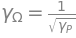

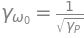

In [20]:
for p in par_nd:
    vec_b = vec_b.subs(Gamma[p], 0)

x_all = mat_A.pinv() @ vec_b

display(mat_A @ x_all - vec_b)
x_all = x_all.subs(Gamma[P], log(P))

for i, q in enumerate(x_all):
   # display(Eq(gm_par[i], q))
    display(Eq(gamma[par_dd[i]], gamma[P]**(q/log(P)))) #log_simp(exp(log(q)))))

### Partial similitude (distorted)

In [10]:
PI_dis = list(map(lambda x: x.subs([
                                    (sigma  , 1),   # keep structural safety
                                    (rho    , 1),   # same material
                                    (X      , 1),   # keep non-dimensional displacement (get rid of X and x)
                                    (t      , 1),   # same time scale
                                    (tau    , 1),   # same time scale
                                    (Omega  , 1),   # same frequency range
                                    (omega  , 1),   # same frequency range
                                    (c      , 1),   # keep damping level
                                    (log(pi), 0),   # get rid of this
                                    (log(2) , 0)]), # get rid of this
                                                    PI_log))
for q in PI_dis:
    display(q)

In [11]:
# xx,aa,bb = get_scaling_factors(PI_dis, par)

In [12]:
PI_gm = PI_dis

for elem in par:
    for i, p in enumerate(PI_gm):
        PI_gm[i] = PI_gm[i].subs(log(elem), Gamma[elem])

PI_gm  = list(map(lambda x: x.lhs - x.rhs, PI_gm))
gm_par = list(map(lambda x: Gamma[x], par))

mat_A, vec_b = coeff_matrix(PI_gm, *gm_par[:-1]) 

display(mat_A, vec_b)

⎡0  0  0  0  0  0  0  0  0  0  0   -1  1   0   0  0   0     0   0  0 ⎤
⎢                                                                    ⎥
⎢0  1  0  0  0  0  0  0  0  0  0   0   1   -1  0  0   0     0   0  0 ⎥
⎢                                                                    ⎥
⎢0  0  0  0  0  0  0  0  0  0  0   0   0   0   0  0   0     0   0  -1⎥
⎢                                                                    ⎥
⎢0  0  0  0  0  1  0  0  0  0  -1  0   1   0   0  0   1     0   0  0 ⎥
⎢                                                                    ⎥
⎢0  0  0  1  0  0  0  0  0  0  0   0   0   0   0  0  1/2   1/2  0  0 ⎥
⎢                                                                    ⎥
⎢0  0  0  0  1  0  0  0  0  0  0   0   -2  -1  0  0   0     0   0  -1⎥
⎢                                                                    ⎥
⎢0  0  0  0  0  0  1  0  0  0  1   0   -2  0   0  0   0     0   0  0 ⎥
⎢                                                                    ⎥
⎢0  0 

⎡    0    ⎤
⎢         ⎥
⎢    0    ⎥
⎢         ⎥
⎢    0    ⎥
⎢         ⎥
⎢    0    ⎥
⎢         ⎥
⎢    0    ⎥
⎢         ⎥
⎢-Gamma[P]⎥
⎢         ⎥
⎢    0    ⎥
⎢         ⎥
⎢    0    ⎥
⎢         ⎥
⎢    0    ⎥
⎢         ⎥
⎣    0    ⎦

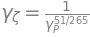

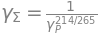

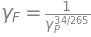

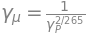

In [13]:
x_dis = mat_A.pinv() @ vec_b

res = mat_A @ x_dis - vec_b
res = map(abs, res)
display(sum(res))

x_dis = x_dis.subs(Gamma[P], log(P))

for i, q in enumerate(x_dis):
   # display(Eq(gm_par[i], q))
    display(Eq(gamma[par[i]], gamma[P]**(q/log(P)))) #log_simp(exp(log(q)))))

In [14]:
# printing.octave.octave_code(params)

In [15]:
get_script = False

if get_script:
    !jupyter nbconvert --to script DA.ipynb

In [16]:
# om_relS = om_rel
# om_relR = om_rel
# s_idx = symbols('(s)')
# r_idx = symbols('(r)')

# pars = [X, B, tau, zeta, Sigma, F, mu, omega, P, Omega, sigma, f, x, m_n, b, t, omega_0, c, k, m, rho, V]
# PI_s = zeros(len(PI), 1)
# PI_r = zeros(len(PI), 1)

# for i in range(len(PI)):
#     for q in pars:
#         PI_s[i] = PI[i].subs(q, q[s_idx])
#         PI_r[i] = PI[i].subs(q, q[r_idx])
#         om_relS = om_relS.subs(q, q[s_idx])
#         om_relR = om_relR.subs(q, q[r_idx])

# display(PI_s, om_relS, om_relR)